seaborn: 

This package was created with the assistance of 
https://towardsdatascience.com/data-cleaning-in-python-the-ultimate-guide-2020-c63b88bf0a0d

However, i modified the input to use PySimpleGUI for ease of selecting files on a computer. 

This is rough. but it works.


In [20]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import matplotlib
plt.style.use('ggplot')
from matplotlib.pyplot import figure

import PySimpleGUI as sg
import os
import codecs # Identifies file encoding types

import memory_profiler as mem_profile
from time import perf_counter, time

# Not sure how to impliment this: https://stackoverflow.com/questions/21971449/how-do-i-increase-the-cell-width-of-the-jupyter-ipython-notebook-in-my-browser
# jt -t oceans16 -f roboto -fs 12 -cellw 100%


SyntaxError: invalid syntax (<ipython-input-20-daa58c5ca1e0>, line 19)

In [21]:
#Make the width of this screen 100%
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
print('Memory (Now): ' + str(mem_profile.memory_usage()) + 'MB' )

Memory (Now): [169.75]MB


In [7]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (12,8)

pd.options.mode.chained_assignment = None

The next uses PySimpleGUI to create a simple form allowing an end user to select their own file for processing.
This must all be maintained in the same Cell, given the 'layout' is disposed of when window = sg.Window is called.

In [8]:
sg.ChangeLookAndFeel('Dark Blue 3')
command_button_size = (15, 1)
layout = [
     [
            # https://pypi.org/project/PySimpleGUI/4.0.0/
            sg.Input(key='_FILEBROWSE_', enable_events=True, visible=False),
            sg.Text('Source File:', size=(9, 1), auto_size_text=False, justification='right'),
            sg.InputText('please select a file to process', key='_FILETOPROCESS_', text_color='gray', size=(98, 1)),
            sg.FileBrowse(
                button_text="Browse",
                file_types=(('CSV Files', '*.csv'), ('TXT Files', '*.txt'), ('All Files', '*.*')),
                initial_folder=os.path.abspath(os.path.dirname("")),
                target='_FILEBROWSE_',
                size = command_button_size
            )

        ]
 ]

def detect_encoding_by_bom( default, file_name_and_path):

    with open(file_name_and_path, 'rb') as f:
        raw = f.read(4)  # will read less if the file is smaller

    # BOM_UTF32_LE's start is equal to BOM_UTF16_LE so need to try the former first
    for enc, boms in \
            ('utf-8-sig', (codecs.BOM_UTF8,)), \
            ('utf-32', (codecs.BOM_UTF32_LE, codecs.BOM_UTF32_BE)), \
            ('utf-16', (codecs.BOM_UTF16_LE, codecs.BOM_UTF16_BE)):

        if any(raw.startswith(bom) for bom in boms):
            if enc != "":
                return enc
            
    print('file encoding type detected: ', default)

    return default

def read_file( file_name_and_path):

    data = pd.DataFrame() # initialize empty df
#     df['filename'] = file_name_and_path
#     data = data.append(df)
    
    # only one in 100 files needs this, but it is enough to cause mischief if it is not implemented.
    encoding = detect_encoding_by_bom('utf-8', file_name_and_path)

    chunks = pd.read_csv(file_name_and_path, chunksize=10000, encoding=encoding )
    data = pd.concat(chunks)
    
    return data


df = pd.DataFrame()
    
window = sg.Window('Data Cleansing', layout, finalize=True)
while True:

    event, values = window.Read()
   
    
    # Allow the app to quit when you press X (close)
    if event in (sg.WIN_CLOSED, 'Exit', None):
        # self.updateStatusBar(window, event, values)
        break
        
    
    # Action #1: Without a File browse, nothing else will occur.
    if event == '_FILEBROWSE_':
        
        # Start the stopwatch / counter 
        t1_start = perf_counter()  
        
        print('Memory (Before): ' + str(mem_profile.memory_usage()) + 'MB' )
        file_name_and_path = values.get('_FILEBROWSE_')
        
        window['_FILETOPROCESS_'](text_color='black') # short hand for updating an element.
        window['_FILETOPROCESS_'](file_name_and_path)# short hand for updating an element.

        import time
        time.sleep(.600)
        
        df = read_file( file_name_and_path)
        window.Close()
        
        print('Memory (After) : ' + str(mem_profile.memory_usage()) + 'MB')
        
        # Stop the stopwatch / counter 
        t1_stop = perf_counter() 
        print("Elapsed time:", t1_stop, t1_start) 
        
        window.Close()

window.Close()


Memory (Before): [170.32421875]MB
file encoding type detected:  utf-8
Memory (After) : [5876.7421875]MB
Elapsed time: 160.3945939 106.7446223


In [9]:
print('d')

d


In [10]:
#print(df)
print(df.shape)
print(df.dtypes)

(14867924, 16)
ADDRESS_DETAIL_PID            object
STREET_LOCALITY_PID           object
LOCALITY_PID                  object
FullAddressDescription        object
BUILDING_NAME                 object
StreetNumber                  object
STREET_NAME                   object
STREET_TYPE_CODE              object
STREET_SUFFIX_DESCRIPTION     object
LOCALITY_NAME                 object
STATE_ABBREVIATION            object
POSTCODE                       int64
LATITUDE                     float64
LONGITUDE                    float64
STREET_CLASS_DESCRIPTION      object
DATE_CREATED                  object
dtype: object


In [15]:
# select numeric columns
df_numeric = df.select_dtypes(include=[np.number])
numeric_cols = df_numeric.columns.values
print('Numeric Columns: \n' , numeric_cols)

Numeric Columns: 
 ['POSTCODE' 'LATITUDE' 'LONGITUDE']


In [14]:
# select non numeric columns
df_non_numeric = df.select_dtypes(exclude=[np.number])
non_numeric_cols = df_non_numeric.columns.values
print('Non Numeric Columns: \n', non_numeric_cols)

Non Numeric Columns: 
 ['ADDRESS_DETAIL_PID' 'STREET_LOCALITY_PID' 'LOCALITY_PID'
 'FullAddressDescription' 'BUILDING_NAME' 'StreetNumber' 'STREET_NAME'
 'STREET_TYPE_CODE' 'STREET_SUFFIX_DESCRIPTION' 'LOCALITY_NAME'
 'STATE_ABBREVIATION' 'STREET_CLASS_DESCRIPTION' 'DATE_CREATED']


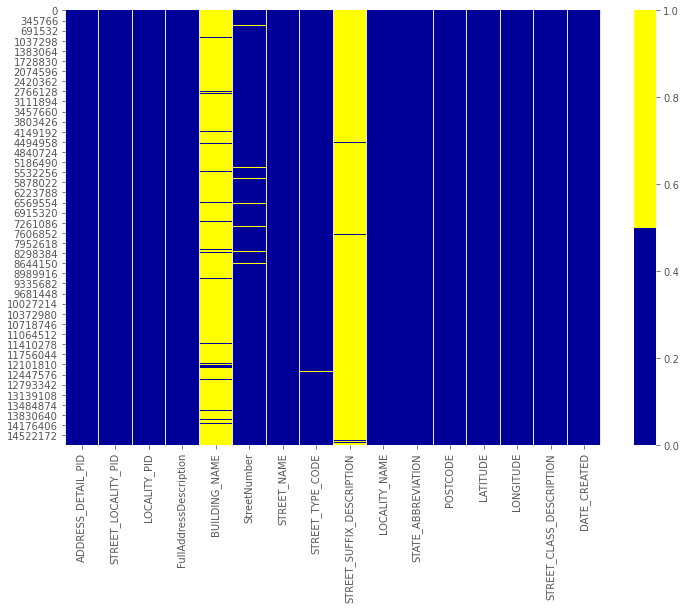

In [16]:
# Create a heat map: yellow indicates missing.   Large datasets may take a long time.
cols = df.columns[:30] # first 30 columns
colours = ['#000099', '#ffff00'] # specify the colours - yellow is missing. blue is not missing.
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [18]:
# Missing Data Percentage List:
# if it's a larger dataset and the visualization takes too long can do this.
# % of missing.
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

ADDRESS_DETAIL_PID - 0.0%
STREET_LOCALITY_PID - 0.0%
LOCALITY_PID - 0.0%
FullAddressDescription - 0.0%
BUILDING_NAME - 95.0%
StreetNumber - 2.0%
STREET_NAME - 0.0%
STREET_TYPE_CODE - 1.0%
STREET_SUFFIX_DESCRIPTION - 99.0%
LOCALITY_NAME - 0.0%
STATE_ABBREVIATION - 0.0%
POSTCODE - 0.0%
LATITUDE - 0.0%
LONGITUDE - 0.0%
STREET_CLASS_DESCRIPTION - 0.0%
DATE_CREATED - 0.0%


created missing indicator for: BUILDING_NAME
created missing indicator for: StreetNumber
created missing indicator for: STREET_TYPE_CODE
created missing indicator for: STREET_SUFFIX_DESCRIPTION


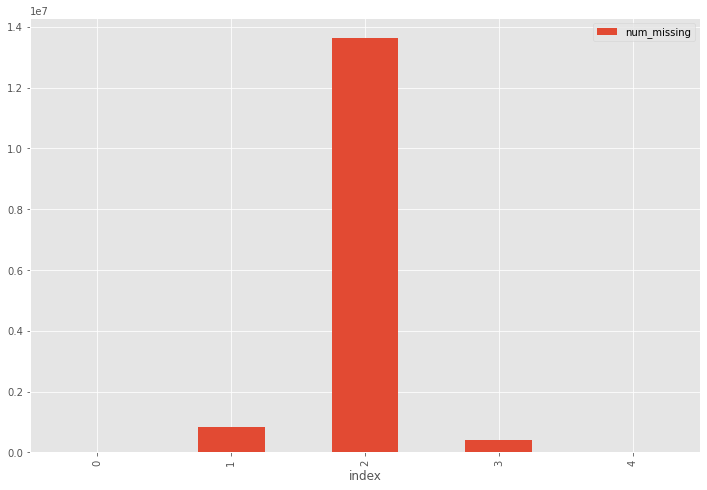

In [19]:
#Missing Data Histogram

# first create missing indicator for features with missing data
for col in df.columns:
    missing = df[col].isnull()
    num_missing = np.sum(missing)
    
    if num_missing > 0:  
        print('created missing indicator for: {}'.format(col))
        df['{}_ismissing'.format(col)] = missing


# then based on the indicator, plot the histogram of missing values
ismissing_cols = [col for col in df.columns if 'ismissing' in col]
df['num_missing'] = df[ismissing_cols].sum(axis=1)

df['num_missing'].value_counts().reset_index().sort_values(by='index').plot.bar(x='index', y='num_missing')


In [ ]:
# not sure how process intensive this would be!
for col in df.columns:
    print('col', col)
#     df[col].hist(bins=100)
#     df.boxplot(column=[ df[col]])
    df[df[col]].describe()
#     df[df[col]].value_counts().plot.bar()


In [24]:
# Unnecessary type #1: Uninformative / Repetitive
num_rows = len(df.index)
low_information_cols = [] #

for col in df.columns:
    cnts = df[col].value_counts(dropna=False)
    top_pct = (cnts/num_rows).iloc[0]
    
    if top_pct > 0.95:
        low_information_cols.append(col)
        print('{0}: {1:.5f}%'.format(col, top_pct*100))
        print(cnts)
        print()
    

STREET_SUFFIX_DESCRIPTION: 99.46791%
NaN           14788813
WEST             21599
EAST             19679
NORTH            18898
SOUTH            18316
EXTENSION          267
MALL               210
CENTRAL            126
DEVIATION            8
SOUTH EAST           6
SOUTH WEST           1
ON                   1
Name: STREET_SUFFIX_DESCRIPTION, dtype: int64

STREET_CLASS_DESCRIPTION: 99.71097%
Confirmed      14824951
Unconfirmed       42973
Name: STREET_CLASS_DESCRIPTION, dtype: int64

StreetNumber_ismissing: 97.94087%
False    14561774
True       306150
Name: StreetNumber_ismissing, dtype: int64

STREET_TYPE_CODE_ismissing: 99.04030%
False    14725237
True       142687
Name: STREET_TYPE_CODE_ismissing, dtype: int64

STREET_SUFFIX_DESCRIPTION_ismissing: 99.46791%
True     14788813
False       79111
Name: STREET_SUFFIX_DESCRIPTION_ismissing, dtype: int64



How to deal with missing data? Options
Solution #1: Drop the Observation
Solution #2: Drop the Feature
Solution #3: Impute the Missing
Solution #4: Replace the Missing


In [ ]:
# we know that column 'id' is unique, but what if we drop it?
df_dedupped = df.drop('ADDRESS_DETAIL_PID', axis=1).drop_duplicates()
df_dedupped = df_dedupped.drop('STREET_LOCALITY_PID', axis=1).drop_duplicates()
# df_dedupped = df_dedupped.drop('LOCALITY_PID', axis=1).drop_duplicates()



# identify duplicate rows
print(df.shape)
print(df_dedupped.shape)